<a href="https://www.kaggle.com/code/rishitjakharia/uci-har?scriptVersionId=211603850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
from numpy import mean, std, dstack

import seaborn as sns
import matplotlib.pyplot as plt 

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, LSTM, TimeDistributed, Permute, Reshape, Conv1D, MaxPooling1D, Add, Layer, GlobalAveragePooling1D

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

from sklearn import metrics
from sklearn.metrics import classification_report

import pandas as pd
from pandas import read_csv

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4145,0.314266,-0.054812,-0.143089,-0.278212,0.185407,-0.307999,-0.32915,0.068565,-0.302307,-0.124104,...,-0.543125,0.528985,-0.959434,-0.214053,-0.452938,0.395892,0.244841,21,2,WALKING_UPSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
2086,0.277257,-0.012293,-0.098603,-0.995322,-0.975674,-0.982278,-0.995304,-0.974502,-0.981933,-0.940481,...,0.065986,0.461425,-0.363904,0.040428,-0.922861,0.139082,0.054161,18,4,SITTING


In [6]:
test.shape

(2947, 564)

In [ ]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

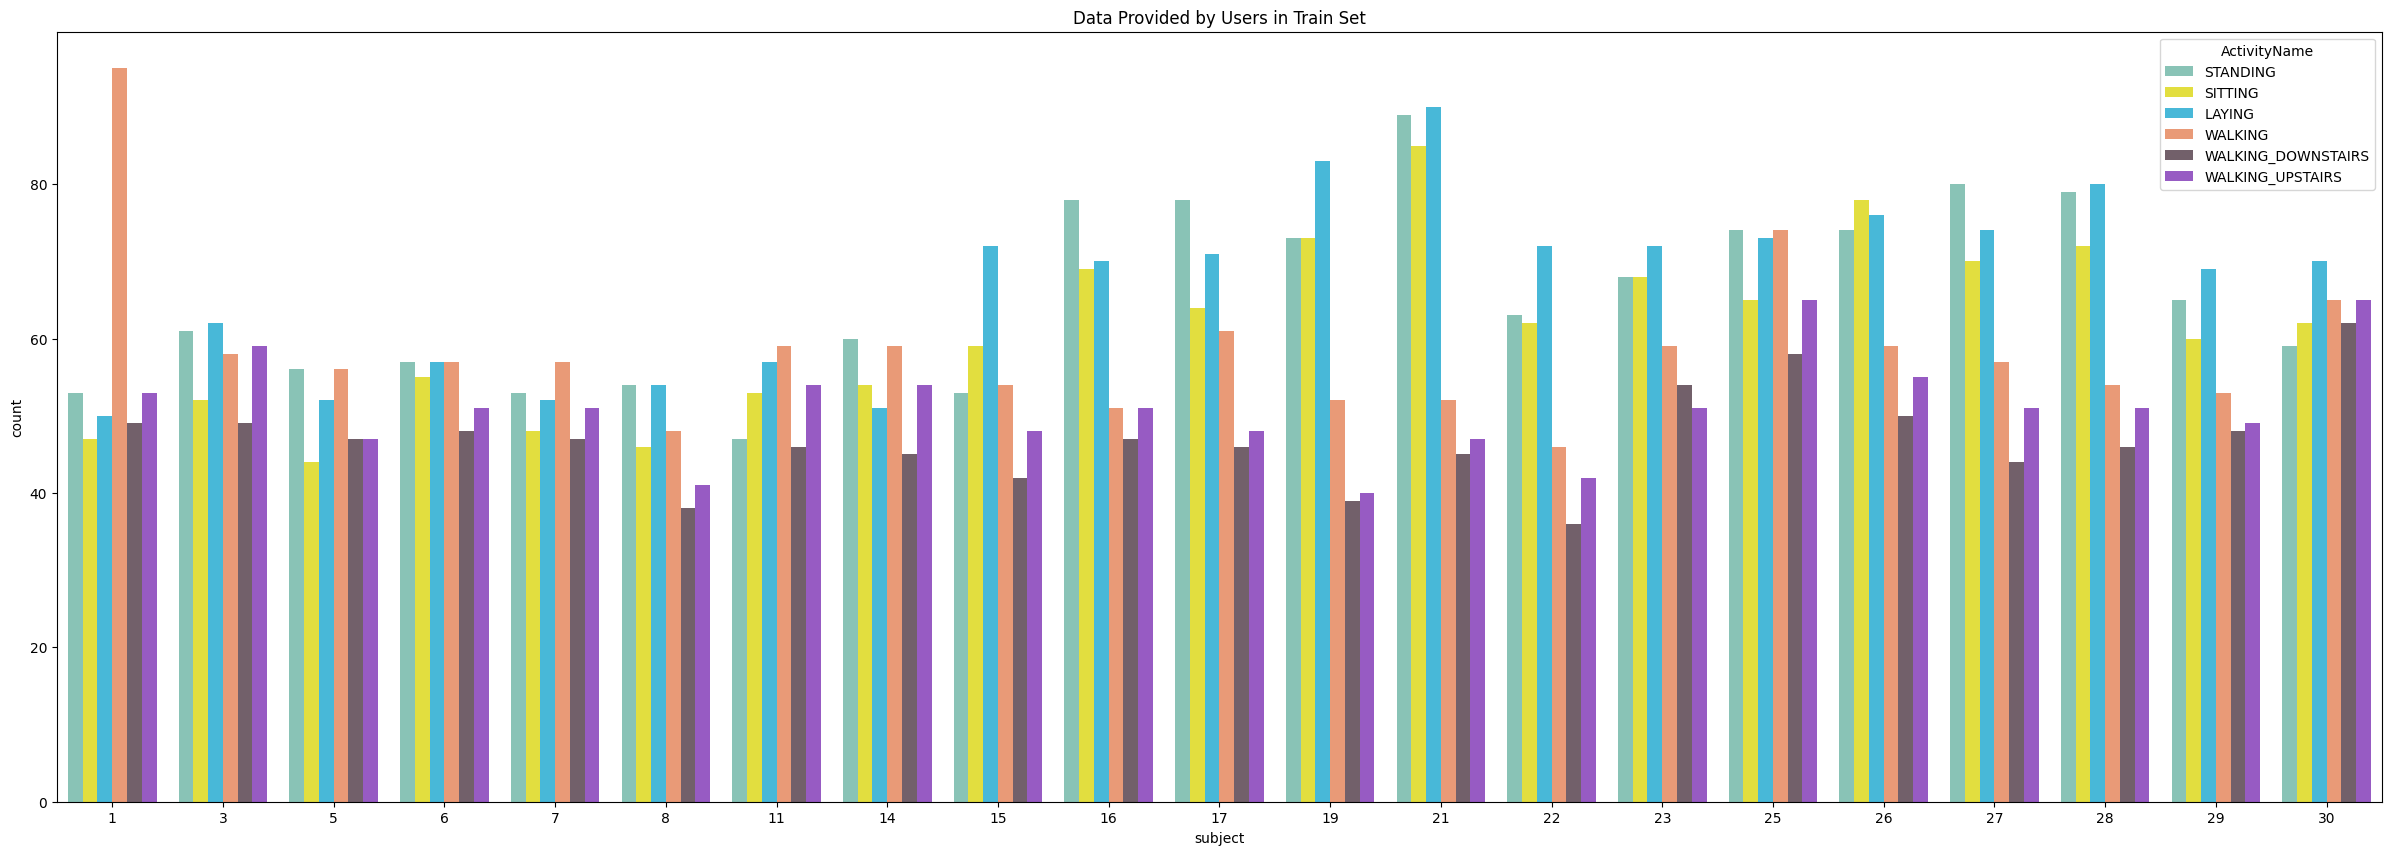

In [7]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

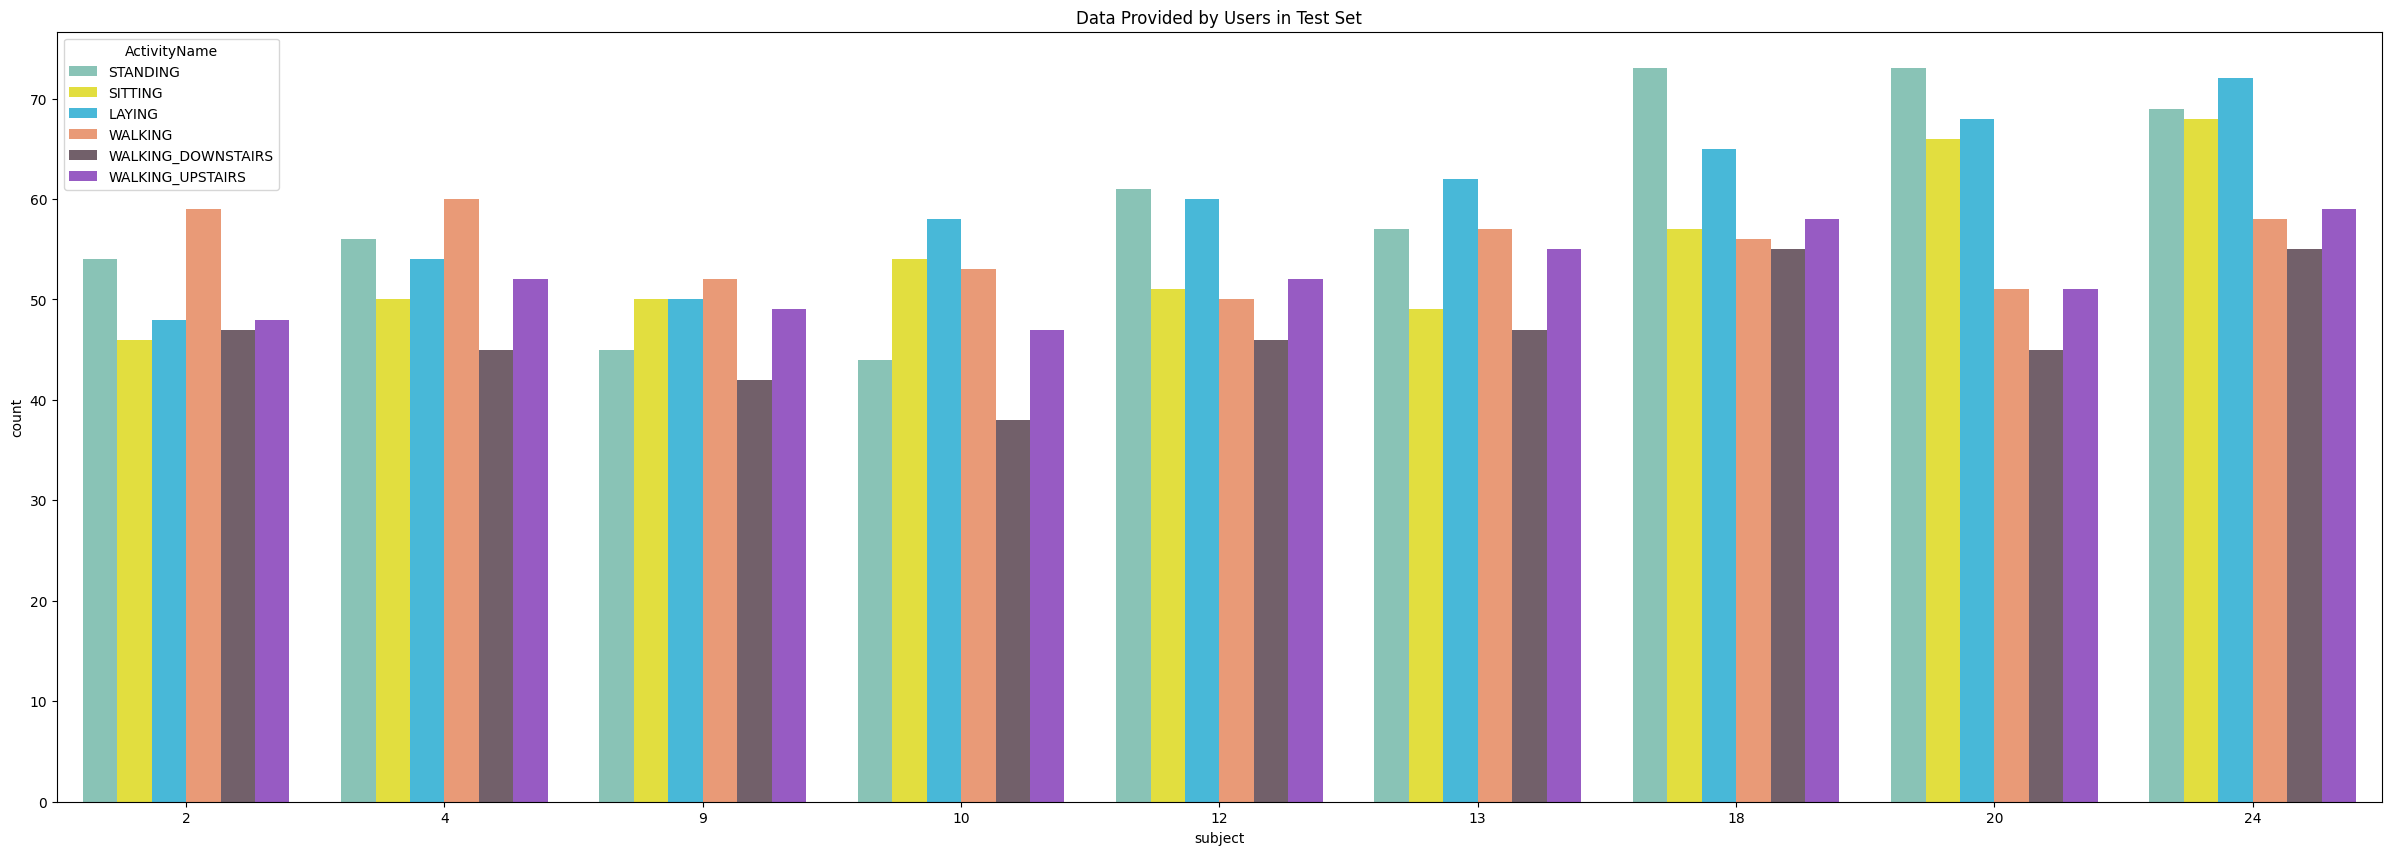

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

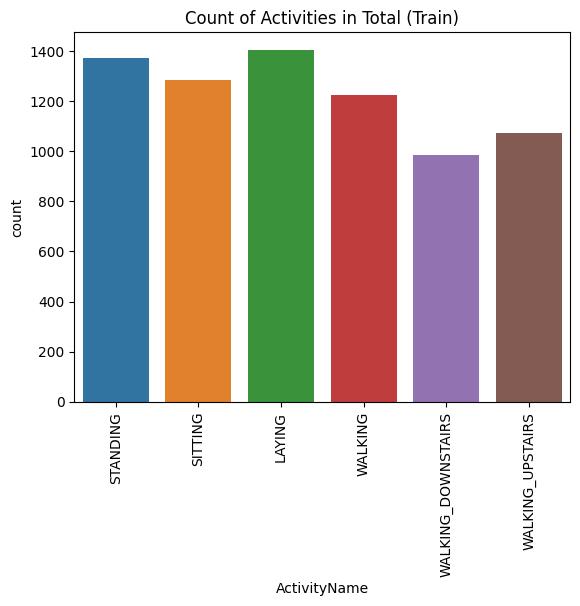

In [9]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

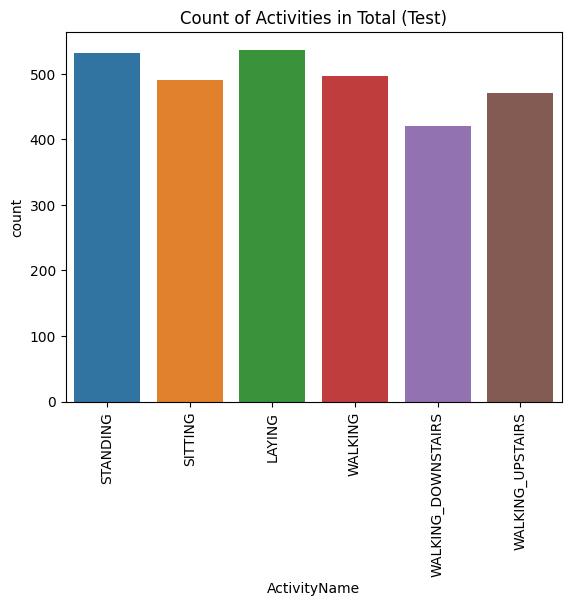

In [10]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [13]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [14]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = dstack(datalist)
    return datalist

In [15]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [16]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [17]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
n_steps = 4
n_length = 32
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 4, 32, 9) (2947, 4, 32, 9)


# Model Training

## ConvLSTM

In [25]:
# Define input shape
input_shape = (None, n_length, n_features)
inputs = Input(shape=input_shape)

# CNN feature extraction part
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'))(inputs)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'))(cnn)
cnn = TimeDistributed(Dropout(0.5))(cnn)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

# LSTM part
# Adjust LSTM units
lstm = LSTM(128)(cnn)
lstm = tf.keras.layers.BatchNormalization()(lstm)
lstm = Dropout(0.3)(lstm)
lstm = Dense(128, activation='relu')(lstm)
lstm = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(lstm)
output = Dense(n_outputs, activation='softmax')(lstm)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [17]:
history=model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=0)

In [18]:
loss , accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

# print(model.summary()) 

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 91.07567071914673


In [19]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


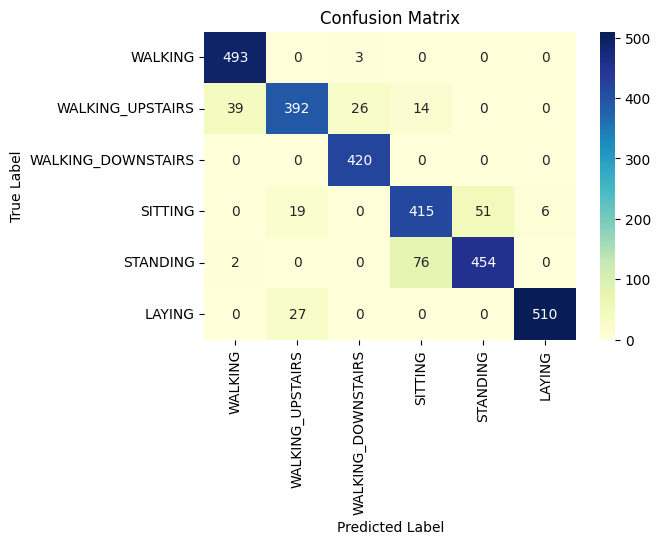

In [20]:
ypred_train = model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## ConvBi-LSTM

In [26]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM, BatchNormalization, Bidirectional

input_shape = (None, n_length, n_features)  
inputs = Input(shape=input_shape)

# CNN feature extraction part
cnn = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(inputs)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'))(cnn)
cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
cnn = TimeDistributed(Dropout(0.5))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

# RNN part 
rnn = Bidirectional(LSTM(128, return_sequences=False))(cnn)
rnn = BatchNormalization()(rnn)
rnn = Dropout(0.3)(rnn)

# Dense layers for classification
dense = Dense(128, activation='relu')(rnn)
dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense)
output = Dense(n_outputs, activation='softmax')(dense)

# Create the model
rcnn_model = Model(inputs=inputs, outputs=output)

# Compile the model
rcnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

rcnn_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, 32, 9)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, None, 30, 64)   │         1,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, None, 15, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, None, 13, 128)  │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, None, 6, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, None, 6, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, None, 768)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,590 (3.77 MB)

 Trainable params: 987,078 (3.77 MB)

 Non-trainable params: 512 (2.00 KB)

In [23]:
history=rcnn_model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=0)

In [24]:
loss , accuracy = rcnn_model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 94.77434754371643


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


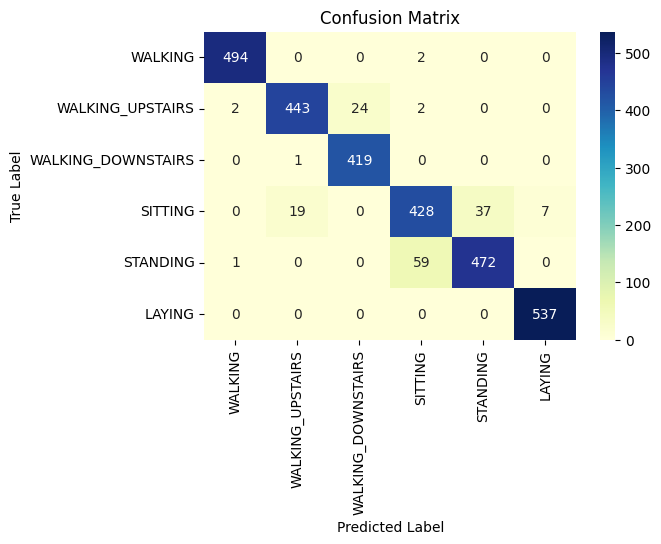

In [25]:
ypred_train = rcnn_model.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = rcnn_model.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## TCN

In [16]:
# !pip install keras-tcn --no-dependencies 

In [17]:
def tcn_block(inputs, filters, kernel_size, dilation_rate):
    # Causal convolution
    conv1 = Conv1D(filters, kernel_size, padding='causal', 
                   dilation_rate=dilation_rate, activation='relu')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    
    # Residual connection
    if inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1)(inputs)
    else:
        shortcut = inputs
    
    output = Add()([conv1, shortcut])
    return output

def create_tcn_model(n_length, n_features, n_outputs):
    inputs = Input(shape=(n_length, n_features))
    
    # TCN-like layers
    x = inputs
    for dilation in [1, 2, 4, 8]:
        x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=dilation)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Output layer
    output = Dense(n_outputs, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

X_tcn = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2] * trainX.shape[3])
X_test_tcn = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2] * testX.shape[3])

n_length = X_tcn.shape[1]
n_features = X_tcn.shape[2]
n_outputs = trainy.shape[1]

tcn_model = create_tcn_model(n_length, n_features, n_outputs)
print(tcn_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4, 288)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4, 64)     │     55,360 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 64)     │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4, 64)     │     18,496 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 4, 64)     │     12,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 64)     │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 4, 64)     │     12,352 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 64)     │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 4, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 4, 64)     │     12,352 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 64)     │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4, 64)     │          0 │ batch_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        390 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 128,902 (503.52 KB)

 Trainable params: 128,390 (501.52 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [18]:
history=tcn_model.fit(X_tcn, trainy, validation_data=(X_test_tcn, testy), epochs=epochs, batch_size=batch_size, verbose=0)

I0000 00:00:1733504408.927792      89 service.cc:145] XLA service 0x7f7aa8014f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733504408.927849      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733504413.563748      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
loss , accuracy = tcn_model.evaluate(X_test_tcn, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 90.19341468811035


230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


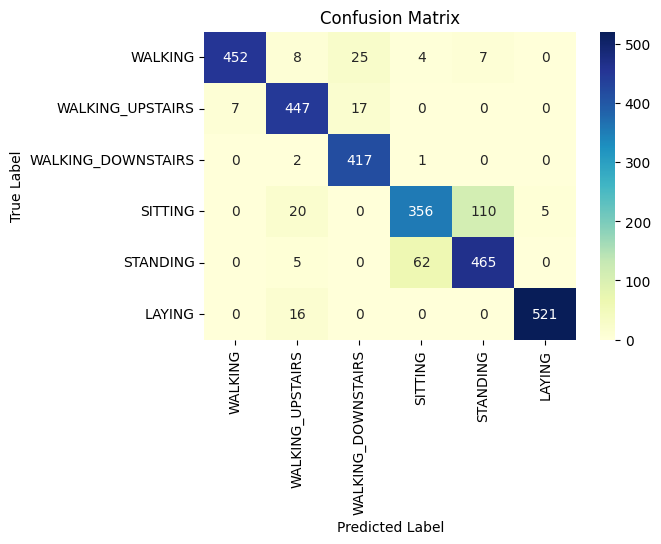

In [20]:
ypred_train = tcn_model.predict(X_tcn)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = tcn_model.predict(X_test_tcn)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Trynig out some other models

### Attention 

In [43]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Multiply, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model

def adaptive_rnn(n_timesteps, n_features, n_outputs):
    # Adjust input shape to be 3D (timesteps, features)
    inputs = Input(shape=(n_timesteps, n_features))
    
    # LSTM layer (Bidirectional LSTM)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    
    # Attention mechanism to weigh timesteps
    attention_scores = Dense(1, activation='sigmoid')(lstm_out)  # Attention weights
    attention_scores = Multiply()([lstm_out, attention_scores])  # Weighted timesteps
    
    # Global average pooling (summarizing attended features)
    x = tf.keras.layers.GlobalAveragePooling1D()(attention_scores)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Output layer
    output = Dense(n_outputs, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model

# Example Usage
n_timesteps = 32  # Adjust according to your data
n_features = 9*4  # Adjust according to your data
n_outputs = 6  # Adjust according to the number of classes in your task

adapt_rnn = adaptive_rnn(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs)
print(adapt_rnn.summary())

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 32, 36)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 32, 256)   │    168,960 │ input_layer_13[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 256)   │      1,024 │ bidirectional_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 32, 1)     │        257 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 32, 256)   │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ multiply_7[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 6)         │        390 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 211,783 (827.28 KB)

 Trainable params: 211,271 (825.28 KB)

 Non-trainable params: 512 (2.00 KB)

None


In [44]:
history=adapt_rnn.fit(trainX.reshape(-1, 32, 9*4), trainy, validation_data=(testX.reshape(-1, 32, 9*4), testy), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5429 - loss: 1.8827 - val_accuracy: 0.3275 - val_loss: 2.1249
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8614 - loss: 0.9367 - val_accuracy: 0.6267 - val_loss: 1.5789
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9310 - loss: 0.5620 - val_accuracy: 0.8392 - val_loss: 1.1178
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9442 - loss: 0.4118 - val_accuracy: 0.9026 - val_loss: 0.8893
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9487 - loss: 0.3146 - val_accuracy: 0.8768 - val_loss: 0.6612
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9556 - loss: 0.2488 - val_accuracy: 0.8734 - val_loss: 0.5252
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9552 - loss: 0.2128 - val_accuracy: 0.8935 - val_loss: 0.4130
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9527 - loss: 0.1859 - val_accuracy: 0.

In [45]:
loss , accuracy = adapt_rnn.evaluate(testX.reshape(-1, 32, 9*4), testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 91.923987865448


230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


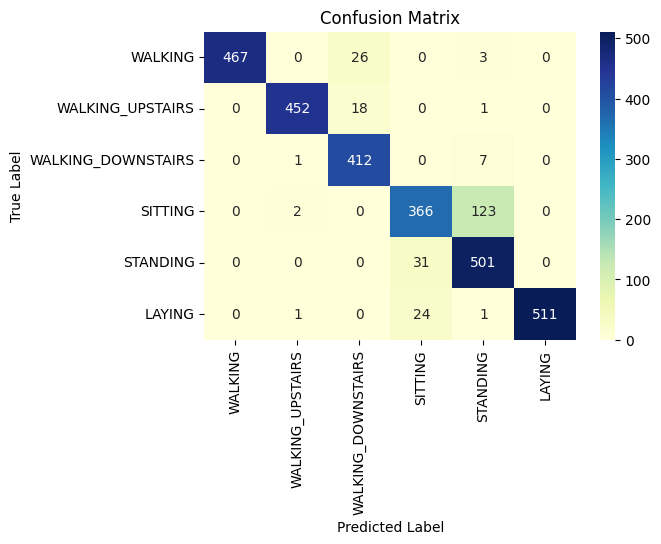

In [46]:
ypred_train = adapt_rnn.predict(trainX.reshape(-1, 32, 9*4))
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = adapt_rnn.predict(testX.reshape(-1, 32, 9*4))
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Inception and Resnet like conv layers

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM, BatchNormalization, Bidirectional, Add, Concatenate, TimeDistributed
from tensorflow.keras import Model

def create_model(n_length, n_features, n_outputs):
    input_shape = (None, n_length, n_features)  # Shape: (batch_size, time_steps, features)
    inputs = Input(shape=input_shape)

    # --- Inception-like block ---
    # Multiple branches with different kernel sizes (1, 3, 5)
    inception_branch1 = TimeDistributed(Conv1D(filters=16, kernel_size=1, activation='relu', padding='same'))(inputs)
    inception_branch2 = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))(inputs)
    inception_branch3 = TimeDistributed(Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))(inputs)

    # Concatenate the branches
    inception_output = Concatenate()([inception_branch1, inception_branch2, inception_branch3])

    # --- ResNet-like block ---
    # First convolution in ResNet block
    resnet_conv1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))(inception_output)
    resnet_conv2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))(resnet_conv1)
    
    # Add the input (skip connection)
    resnet_output = Add()([inception_output, resnet_conv2])

    # --- CNN Layer (after Inception and ResNet blocks) ---
    cnn = TimeDistributed(MaxPooling1D(pool_size=2))(resnet_output)
    cnn = TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'))(cnn)
    cnn = TimeDistributed(MaxPooling1D(pool_size=2))(cnn)
    cnn = TimeDistributed(Dropout(0.3))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)

    # --- RNN part ---
    rnn = Bidirectional(LSTM(128, return_sequences=False))(cnn)
    rnn = BatchNormalization()(rnn)
    rnn = Dropout(0.3)(rnn)

    # --- Dense layers for classification ---
    dense = Dense(128, activation='relu')(rnn)
    dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense)
    output = Dense(n_outputs, activation='softmax')(dense)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

# Example Usage
n_length = 32  # Sequence length (timesteps)
n_features = 9  # Number of features per timestep
n_outputs = 6   # Number of output classes

res_ception_lstm = create_model(n_length, n_features, n_outputs)
res_ception_lstm.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 32,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, None, 32,  │        160 │ input_layer_4[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, None, 32,  │        896 │ input_layer_4[0]… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, None, 32,  │        736 │ input_layer_4[0]… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 32,  │          0 │ time_distributed… │
│ (Concatenate)       │ 64)               │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, None, 32,  │     12,352 │ concatenate_4[0]… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, None, 32,  │     12,352 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 32,  │          0 │ concatenate_4[0]… │
│                     │ 64)               │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, None, 16,  │          0 │ add_2[0][0]       │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, None, 14,  │     24,704 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, None, 7,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, None, 7,   │          0 │ time_distributed… │
│ (TimeDistributed)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, None, 896) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │  1,049,600 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0] 

 Total params: 1,143,366 (4.36 MB)

 Trainable params: 1,142,854 (4.36 MB)

 Non-trainable params: 512 (2.00 KB)

In [18]:
history=res_ception_lstm.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.6394 - loss: 1.6913 - val_accuracy: 0.3722 - val_loss: 2.3039
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9146 - loss: 0.8454 - val_accuracy: 0.4968 - val_loss: 1.7381
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9474 - loss: 0.5881 - val_accuracy: 0.8191 - val_loss: 1.1782
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9540 - loss: 0.4445 - val_accuracy: 0.8789 - val_loss: 0.8770
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9540 - loss: 0.3486 - val_accuracy: 0.8758 - val_loss: 0.7262
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9564 - loss: 0.2839 - val_accuracy: 0.9094 - val_loss: 0.5615
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9542 - loss: 0.2375 - val_accuracy: 0.9060 - val_loss: 0.4286
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9585 - loss: 0.1979 - val_accuracy: 0

In [20]:
loss , accuracy = res_ception_lstm.evaluate(testX, testy, batch_size=batch_size, verbose=0)

score=accuracy*100
print('Accuracy = {}'.format(score))

Accuracy = 92.97590851783752


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


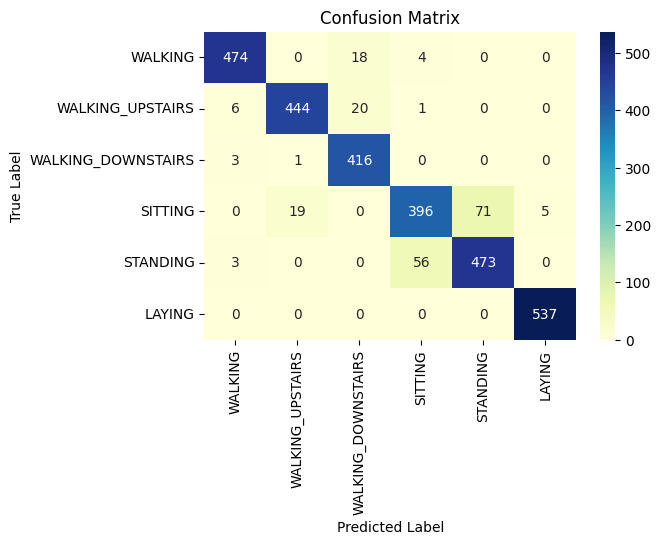

In [21]:
ypred_train = res_ception_lstm.predict(trainX)
max_ypred_train = np.argmax(ypred_train, axis=1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
ypred_test = res_ception_lstm.predict(testX)
max_ypred_test = np.argmax(ypred_test, axis=1)
max_ytest = np.argmax(testy, axis=1)
matrix = metrics.confusion_matrix(max_ytest, max_ypred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### CBAM - Convolutional block Attention Module